In [0]:
# The computation was done on google colab
# First Load the Drive helper and mount

from google.colab import drive 

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/files_4096_128')
# setting the working directory
os.getcwd() 

'/content/drive/My Drive/Hebin/files_4096_128'

This is a dataset with dw starting at 0

1024 arrays

64 x 64

Update: arrays are min-max scaled

In [0]:
import numpy as np
import pandas as pd
import glob
import sys
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn
import matplotlib.mlab as mlab
import matplotlib.colors
%matplotlib inline

from keras import layers
from keras import models
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.optimizers import RMSprop, Adam, Adadelta

from keras.preprocessing.image import ImageDataGenerator

import cv2

Using TensorFlow backend.


In [0]:
np.random.seed(42)

In [0]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [0]:
# Each array is a csv file. So first need to read each file using pandas to convert it into a data frame

full = range(1,4097)

file_names = [str(i)+".csv" for i in full]




In [0]:
X_train = file_names

X_train = [pd.read_csv(i, header=None) for i in X_train]
  
  
X_train = [np.array(i) for i in X_train]
  


In [0]:
X_train[0].shape

(128, 128)

In [0]:
# The labels are in the file labels.csv
y_train = pd.read_csv('labels.csv', header= None)

In [0]:
# selecting some of the samples for visualization
locations = np.arange(8)

labels = [str(i) for i in np.arange(374,376,0.25)]

len(locations), len(labels)

(8, 8)

In [0]:
fig = plt.figure(figsize=(12,12),constrained_layout=True)


k = [0, 32, 48, 1024, 1024+32, 1024+48, 2048, 2048+32, 2048+48]
for i in range(0,9):
  j = k[i]
  plt.subplot(3,3,i+1)
  plt.contour(X_train[j],20)
  plt.title("$\gamma$ = " + str(np.round(y_train.loc[j][0], 3)) + " & $\sigma$ = " + str(np.round(y_train.loc[j][1], 3))  ,fontsize = 10)
  plt.xticks(np.arange(0,135,60) ,np.arange(374,376.5), fontsize=10)
  plt.yticks(np.arange(0,135,60) ,np.arange(374,376.5), fontsize=10)



plt.savefig("contours.eps")

In [0]:



k = [0, 32, 1024, 1024+32]
for i in range(0,3):
  j = k[i]
  plt.figure(figsize=(1.5,1.5))
  plt.contour(X_train[j],20, cmap='inferno')
  plt.title("$\gamma$ = " + str(np.round(y_train.loc[j][0], 3)) + " & $\sigma$ = " + str(np.round(y_train.loc[j][1], 3))  ,fontsize = 8)
  plt.xticks(np.arange(0,135,60) ,np.arange(374,376.5), fontsize=6)
  plt.yticks(np.arange(0,135,60) ,np.arange(374,376.5), fontsize=6)
  plt.savefig("contour" + str(i) + ".svg")

  
plt.figure(figsize=(1.85,1.5))
cs = plt.contour(X_train[k[3]],20, cmap='inferno')
plt.title("$\gamma$ = " + str(np.round(y_train.loc[k[3]][0], 3)) + " & $\sigma$ = " + str(np.round(y_train.loc[k[3]][1], 3))  ,fontsize = 8)
plt.xticks(np.arange(0,135,60) ,np.arange(374,376.5), fontsize=6)
plt.yticks(np.arange(0,135,60) ,np.arange(374,376.5), fontsize=6)
norm= matplotlib.colors.Normalize(vmin=cs.cvalues.min(), vmax=cs.cvalues.max())
# a previous version of this used
#norm= matplotlib.colors.Normalize(vmin=cs.vmin, vmax=cs.vmax)
# which does not work any more
sm = plt.cm.ScalarMappable(norm=norm, cmap = cs.cmap)
sm.set_array([])
plt.colorbar(sm)
plt.savefig("contour" + str(3) + ".svg")


In [0]:
# min max scaling the arrays
def scaler(numpy_array):
  array_min = np.min(numpy_array)
  array_range = np.max(numpy_array) - np.min(numpy_array)
  
  return (numpy_array - array_min)/array_range

In [0]:
X_train = [scaler(i) for i in X_train]

In [0]:
X_train = np.array([i.reshape((128,128,1)) for i in X_train])

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)
  

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3686, 128, 128, 1), (3686, 2), (410, 128, 128, 1), (410, 2))

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='linear'))

  
  
opt = Adam(lr=0.00001)
model.compile(loss='mean_squared_error', optimizer= opt, metrics=[coeff_determination])
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1)
  

W0820 20:03:18.603954 140110623844224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 20:03:18.643021 140110623844224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 20:03:18.651204 140110623844224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 20:03:18.678028 140110623844224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0820 20:03:18.745629 140110623844224 deprecation_wrapp

Train on 3317 samples, validate on 369 samples
Epoch 1/200
3317/3317 [==============================] - 9s 3ms/step - loss: 0.0020 - coeff_determination: 0.6565 - val_loss: 5.8409e-04 - val_coeff_determination: 0.9086
Epoch 2/200
3317/3317 [==============================] - 2s 613us/step - loss: 2.2866e-04 - coeff_determination: 0.9628 - val_loss: 1.7230e-04 - val_coeff_determination: 0.9722
Epoch 3/200
3317/3317 [==============================] - 2s 610us/step - loss: 9.4934e-05 - coeff_determination: 0.9845 - val_loss: 8.1768e-05 - val_coeff_determination: 0.9872
Epoch 4/200
3317/3317 [==============================] - 2s 611us/step - loss: 6.6663e-05 - coeff_determination: 0.9892 - val_loss: 6.6112e-05 - val_coeff_determination: 0.9899
Epoch 5/200
3317/3317 [==============================] - 2s 617us/step - loss: 5.2318e-05 - coeff_determination: 0.9914 - val_loss: 6.0973e-05 - val_coeff_determination: 0.9903
Epoch 6/200
3317/3317 [==============================] - 2s 614us/step - l

In [0]:
plt.plot(history.history['coeff_determination'])
plt.plot(history.history['val_coeff_determination'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.xlim(-10,200)
plt.savefig("loss.svg")

In [0]:
# for loading trained weights

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='linear'))

model.load_weights("right_128_99percent.h5")

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [0]:
y_pred = model.predict(X_test)

#y_pred = np.round(y_pred, 3)

y_pred = pd.DataFrame(y_pred)

y_pred.columns = ['Homogeneous predicted', 'Inhomogeneous predicted']

#y_test = np.round(y_test, 3)

y_test = pd.DataFrame(y_test)

y_test.columns = ['Homogeneous actual', 'Inhomogeneous actual']

y_test.index = y_pred.index

comp = y_test.join(y_pred)

comp.head()

,Homogeneous actual,Inhomogeneous actual,Homogeneous predicted,Inhomogeneous predicted
0,0.095921,0.060317,0.096553,0.060865
1,0.095921,0.184130,0.096270,0.184925
2,0.285760,0.104760,0.286543,0.104955
3,0.152870,0.111110,0.153122,0.111923
4,0.110160,0.082540,0.110719,0.083288


In [0]:
comp['Homo_error'] = (comp['Homogeneous predicted'] - comp['Homogeneous actual'])/comp['Homogeneous actual']

comp['inHomo_error'] = (comp['Inhomogeneous predicted'] - comp['Inhomogeneous actual'])/comp['Inhomogeneous actual']

comp['ratio'] = comp['Inhomogeneous actual']/comp['Homogeneous actual']


In [0]:
comp.head()

,Homogeneous actual,Inhomogeneous actual,Homogeneous predicted,Inhomogeneous predicted,Homo_error,inHomo_error,ratio
0,0.095921,0.060317,0.096553,0.060865,0.006587,0.009078,1.590281
1,0.095921,0.184130,0.096270,0.184925,0.003642,0.004319,0.520942
2,0.285760,0.104760,0.286543,0.104955,0.002738,0.001863,2.727759
3,0.152870,0.111110,0.153122,0.111923,0.001651,0.007314,1.375844
4,0.110160,0.082540,0.110719,0.083288,0.005073,0.009063,1.334626


In [0]:
max(comp2['ratio'])

91.51074151074151

In [0]:
#comp.to_csv("pred_vs_actual_1.csv")

In [0]:
#model.save_weights("right_128_99percent.h5")

In [0]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.9995095574980697

In [0]:
comp1 = comp[(comp['Homogeneous actual'] > 0.032)]
comp1 = comp1[comp1['Inhomogeneous actual'] > 0]
comp2 = comp[comp['Homogeneous actual'] > 0.0]
comp2 = comp2[comp2['Inhomogeneous actual'] > 0.0]
comp.shape, comp1.shape, comp2.shape

((410, 7), (350, 7), (405, 7))

In [0]:
comp1.describe()

,Homogeneous actual,Inhomogeneous actual,Homogeneous predicted,Inhomogeneous predicted,Homo_error,inHomo_error,ratio
count,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000
mean,0.158610,0.105072,0.159139,0.104988,0.007144,-0.008574,1.083178
std,0.083084,0.057637,0.082957,0.058555,0.011273,0.142089,1.395600
min,0.019984,0.003175,0.020963,0.002628,-0.001368,-0.427218,0.010928
25%,0.086429,0.057143,0.087198,0.054627,0.001210,0.000939,0.351931
50%,0.157620,0.104760,0.157707,0.105661,0.003416,0.004021,0.690570
75%,0.238300,0.155560,0.238372,0.156429,0.007389,0.006246,1.185525
max,0.300000,0.200000,0.300878,0.201342,0.070728,1.751664,9.849380


In [0]:
comp2.describe()

,Homogeneous actual,Inhomogeneous actual,Homogeneous predicted,Inhomogeneous predicted,Homo_error,inHomo_error,ratio
count,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,0.174775,0.105237,0.175250,0.105110,0.003793,-0.009217,4.227594
std,0.074008,0.057853,0.073954,0.058872,0.003674,0.150467,10.221761
min,0.053206,0.003175,0.053712,0.002628,-0.001368,-0.427218,0.294037
25%,0.112530,0.055555,0.112827,0.054584,0.001027,0.000132,1.039865
50%,0.167110,0.104760,0.167654,0.105661,0.002938,0.004083,1.551531
75%,0.243050,0.158730,0.243678,0.159301,0.004898,0.006315,3.204512
max,0.300000,0.200000,0.300878,0.201342,0.019865,1.751664,91.510742


In [0]:
comp_low = comp1[(comp1['ratio'] < 0.25)]
comp_high = comp1[(comp1['ratio'] > 2.5)]
comp_med = comp1[(comp1['ratio'] > 0.25)]
comp_med = comp_med[(comp_med['ratio'] < 2.5)]

In [0]:
a=4
plt.figure(figsize= (3.5,2),dpi=300,edgecolor='black')
plt.scatter(comp_med['Homogeneous actual'], (100*(comp_med['Homo_error'])), c ='gray',label = '0.25 < Ratio < 2.5',s=a )
plt.scatter(comp_low['Homogeneous actual'], (100*(comp_low['Homo_error'])), c ='blue' ,label = 'Ratio < 0.25', s=a)
plt.scatter(comp_high['Homogeneous actual'], (100*(comp_high['Homo_error'])), c ='red',label = 'Ratio > 2.5',s=a)

#plt.ylim(0,2.5)
plt.ylabel('Error (%)', fontsize = 10)
plt.xlabel('$\gamma$ (THz)', fontsize = 10)
plt.axhline(y=2, c ='black')
plt.axhline(y=-2, c ='black')
plt.ylim(-7.5,7.5)
plt.xlim(0.0,0.3)
plt.legend(loc = 'center right',bbox_to_anchor=(2.5, 0.5), fontsize = 10)
plt.savefig("error1.svg")

In [0]:
plt.figure(figsize= (3.5,2),dpi=300,edgecolor='black')
a=4

plt.scatter(comp_med['Inhomogeneous actual'], (100*(comp_med['inHomo_error'])), c ='gray',label = '0.25 < Ratio < 2.5',s=a )
plt.scatter(comp_low['Inhomogeneous actual'], (100*(comp_low['inHomo_error'])), c ='blue',label = 'Ratio < 0.25',s=a )
plt.scatter(comp_high['Inhomogeneous actual'], (100*(comp_high['inHomo_error'])), c ='red',label = 'Ratio > 2.5',s=a )


plt.ylabel('Error (%)', fontsize = 10)
plt.xlabel('$\sigma$ (THz)', fontsize = 10)
plt.axhline(y=2, c ='black')
plt.axhline(y=-2, c ='black')
plt.ylim(-7.5,7.5)
plt.xlim(0.00,0.2)
plt.savefig("error2.svg")

In [0]:
comp2[comp2['inHomo_error'] < -0.01]

In [0]:
x_axis = pd.read_excel('KVapor/xAxis.xlsx', header = None)

x_axis.head()

,0
0,390.002227
1,390.015817
2,390.029407
3,390.042998
4,390.056588


In [0]:
x_axis.describe()

,0
count,148.000000
mean,391.001119
std,0.582592
min,390.002227
25%,390.501673
50%,391.001119
75%,391.500565
max,392.000011


In [0]:
y_axis = pd.read_excel('KVapor/yAxis.xlsx', header = None)
#y_axis = y_axis.apply(np.abs)
y_axis.head()

,0
0,-390.001823
1,-390.016277
2,-390.030730
3,-390.045184
4,-390.059637


In [0]:
y_axis.describe()

,0
count,139.000000
mean,-390.999117
std,0.582043
min,-391.996411
25%,-391.497764
50%,-390.999117
75%,-390.500470
max,-390.001823


In [0]:
exp = pd.read_table('kvapor.dat', header=None)

exp.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147
0,0.000124,0.000573,0.000606,0.000348,0.000737,0.000844,0.001016,0.001856,0.002256,0.001638,0.000289,0.000961,0.001237,0.000506,0.000739,0.001326,0.001056,0.000755,0.001214,0.001170,0.000915,0.001530,0.002006,0.001898,0.001671,0.001636,0.001609,0.001671,0.001816,0.001867,0.001848,0.001778,0.001727,0.002002,0.002310,0.002311,0.002390,0.002778,0.002816,0.002411,...,0.003295,0.003500,0.003469,0.003207,0.003318,0.003388,0.003086,0.002965,0.002981,0.002597,0.002194,0.002317,0.002496,0.002584,0.002533,0.002190,0.002327,0.003018,0.003013,0.002175,0.001839,0.002216,0.002065,0.001813,0.002094,0.002155,0.002111,0.002319,0.002142,0.001484,0.001432,0.001714,0.001384,0.000980,0.001186,0.001267,0.001278,0.001437,0.001408,0.001289
1,0.000406,0.000665,0.000401,0.000391,0.000761,0.000817,0.001140,0.001600,0.001415,0.000526,0.000744,0.001296,0.001055,0.001030,0.001552,0.001551,0.001313,0.001642,0.001728,0.001297,0.001471,0.002037,0.002030,0.001762,0.001791,0.001788,0.001778,0.002048,0.002170,0.002087,0.002128,0.002205,0.002361,0.002816,0.003037,0.002816,0.002804,0.003084,0.002935,0.002790,...,0.003246,0.003725,0.003475,0.003017,0.003111,0.003005,0.002610,0.002764,0.002854,0.002301,0.002222,0.002939,0.003103,0.002653,0.002463,0.002827,0.003106,0.002909,0.002333,0.002026,0.002197,0.002172,0.002037,0.002181,0.002185,0.001826,0.001662,0.001641,0.001299,0.001229,0.001567,0.001459,0.001095,0.001325,0.001598,0.001579,0.001585,0.001618,0.001532,0.001450
2,0.000686,0.000690,0.000592,0.000863,0.001020,0.001051,0.001246,0.001190,0.000588,0.000764,0.001568,0.001840,0.001750,0.001716,0.001654,0.001683,0.001988,0.001937,0.001304,0.001274,0.001908,0.002021,0.001845,0.001938,0.001970,0.002029,0.002460,0.002663,0.002429,0.002460,0.002710,0.002723,0.002919,0.003312,0.003188,0.002826,0.003015,0.003264,0.003248,0.003619,...,0.004142,0.004321,0.003734,0.003391,0.003542,0.003339,0.003330,0.003762,0.003507,0.002825,0.003291,0.003871,0.003343,0.002747,0.003274,0.003581,0.003000,0.002360,0.002364,0.002423,0.002248,0.002105,0.002113,0.001973,0.001616,0.001384,0.001623,0.001876,0.001953,0.001998,0.001950,0.001744,0.001678,0.001842,0.001907,0.001796,0.001639,0.001514,0.001424,0.001280
3,0.001161,0.001121,0.001038,0.001100,0.001091,0.001110,0.001177,0.001102,0.001195,0.001561,0.001826,0.001942,0.001900,0.001578,0.001541,0.002069,0.002096,0.001247,0.001159,0.002063,0.002247,0.002061,0.002290,0.002399,0.002331,0.002729,0.002997,0.002637,0.002521,0.002952,0.002965,0.002795,0.003104,0.003223,0.002885,0.002977,0.003406,0.003545,0.003741,0.004047,...,0.004715,0.004633,0.004096,0.003901,0.004019,0.003991,0.004163,0.004235,0.003588,0.003106,0.003611,0.003672,0.002994,0.003075,0.003590,0.003204,0.002357,0.002421,0.002648,0.002315,0.002033,0.002116,0.002111,0.001990,0.002036,0.002269,0.002632,0.002785,0.002543,0.002177,0.002053,0.001990,0.001827,0.001780,0.001773,0.001530,0.001209,0.001219,0.001313,0.001233
4,0.001460,0.001235,0.001118,0.001099,0.001063,0.001221,0.001446,0.001683,0.001935,0.001974,0.001913,0.002048,0.002041,0.001841,0.002105,0.002322,0.001727,0.001378,0.002352,0.002755,0.002497,0.002646,0.002948,0.002707,0.002670,0.002990,0.002820,0.002689,0.003218,0.003342,0.002905,0.002988,0.003326,0.003191,0.003285,0.003781,0.003887,0.003838,0.004050,0.004063,...,0.004502,0.004501,0.004060,0.003837,0.004003,0.004023,0.003869,0.003578,0.003071,0.002879,0.003169,0.003199,0.003003,0.003125,0.003155,0.002743,0.002504,0.002635,0.002439,0.002089,0.002258,0.002546,0.002580,0.002543,0.002605,0.002667,0.002669,0.002389,0.001873,0.001652,0.001795,0.001676,0.001349,0.001303,0.001238,0.000914,0.001016,0.001435,0.001516,0.001402


In [0]:
np.array(exp).shape , x_axis[0].shape

((139, 148), (148,))

In [0]:
from scipy.interpolate import RectBivariateSpline as interp

spline = interp(np.abs(y_axis[0]),x_axis[0], np.array(exp))

p = np.linspace(390,392,128)
q = np.linspace(390,392,128)

pq = np.zeros((128,128))
pq.shape

for i in range(128):
  for j in range(128):
    pq[i,j] = spline.ev(p[i],q[j])

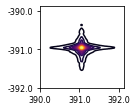

In [0]:
plt.figure(figsize= (1.5,1.5))
plt.contour(pq,20,cmap='inferno')
plt.xticks(np.arange(0,135,60) ,np.arange(390,392.5), fontsize=8)
plt.yticks(np.arange(0,135,60) ,np.arange(-392,-389.5), fontsize=8)

#plt.xlabel("Frequency (THz)", fontsize=8)
#plt.ylabel("Frequency (THz)", fontsize=8)


plt.savefig("kvape_actual.svg")

In [0]:
def test(df):
  
  
  
  df_extract = scaler(df)
  

  plt.figure(figsize=(4,4))
  plt.contour(df_extract,20)
  #plt.xticks(np.arange(0,135,30) ,np.arange(372,374.5,0.5), fontsize=10)
  #plt.yticks(np.arange(0,135,30) ,np.arange(372,374.5,0.5), fontsize=10)

  
  df_extract = df_extract.reshape((1,128,128,1))
  
  k = model.predict(df_extract)[0]
  
  for i in range(2):
    if k[i] < 0:
      k[i] = 0
  
  return k

  

array([0.0384432, 0.0083135], dtype=float32)

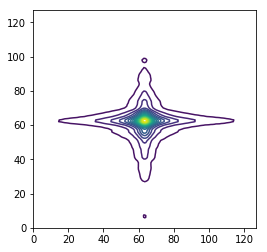

In [0]:
test(pq)

In [0]:
df1 = df[df['lambda_tu'] > 0.038]
df1 = df1[df1['lambda_tu'] < 0.04]
df1 = df1[df1['dw'] < 0.01]

df1

,lambda_tu,dw,file
512,0.038968,0.000000,513.csv
513,0.038968,0.003175,514.csv
514,0.038968,0.006349,515.csv
515,0.038968,0.009524,516.csv


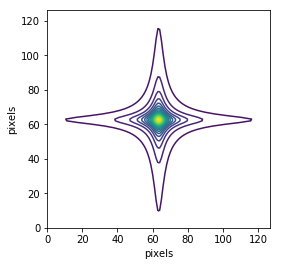

In [0]:
plt.figure(figsize=(4,4))
plt.contour(np.array(pd.read_csv('516.csv')), 20)

plt.xlabel("pixels", fontsize=10)
plt.ylabel("pixels", fontsize=10)

plt.savefig("kvape_pred.eps")

In [0]:
x_axis = pd.read_excel('QuantumWells/xAxis.xlsx', header = None)

x_axis.head()

,0
0,372.606256
1,372.618805
2,372.631354
3,372.643903
4,372.656451


In [0]:
x_axis.describe()

,0
count,160.000000
mean,373.603885
std,0.581412
min,372.606256
25%,373.105071
50%,373.603885
75%,374.102699
max,374.601513


In [0]:
y_axis = pd.read_excel('QuantumWells/yAxis.xlsx', header = None)
#y_axis = y_axis.apply(np.abs)
y_axis.head()

,0
0,-372.602163
1,-372.609390
2,-372.616616
3,-372.623843
4,-372.631070


In [0]:
y_axis.describe()

,0
count,277.000000
mean,-373.599457
std,0.578916
min,-374.596750
25%,-374.098104
50%,-373.599457
75%,-373.100810
max,-372.602163


In [0]:
exp3 = pd.read_table('quantum.dat', header=None)

exp3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159
0,0.004178,0.004726,0.005244,0.005532,0.004930,0.004883,0.005469,0.005299,0.005342,0.005341,0.005346,0.005573,0.005695,0.006052,0.005940,0.005748,0.005717,0.005548,0.005810,0.005654,0.005564,0.005552,0.005111,0.005620,0.006059,0.006190,0.006255,0.006458,0.007492,0.007590,0.007494,0.007733,0.007613,0.008446,0.008658,0.009076,0.009902,0.008598,0.008629,0.009562,...,0.005902,0.005184,0.004966,0.004676,0.004231,0.004041,0.003631,0.003205,0.003088,0.003004,0.002899,0.003047,0.003486,0.003669,0.003711,0.003785,0.003583,0.003522,0.003583,0.003346,0.003100,0.002979,0.002912,0.002750,0.002583,0.002630,0.002506,0.002413,0.002588,0.002706,0.002713,0.002560,0.002569,0.002624,0.002449,0.002544,0.002663,0.002595,0.002700,0.002716
1,0.004267,0.004828,0.005319,0.005555,0.004905,0.004921,0.005509,0.005335,0.005411,0.005382,0.005410,0.005666,0.005792,0.006129,0.005976,0.005793,0.005735,0.005567,0.005862,0.005664,0.005584,0.005588,0.005157,0.005702,0.006133,0.006243,0.006291,0.006566,0.007604,0.007638,0.007574,0.007802,0.007722,0.008600,0.008792,0.009242,0.009925,0.008568,0.008779,0.009610,...,0.005996,0.005295,0.005105,0.004793,0.004353,0.004190,0.003789,0.003372,0.003252,0.003170,0.003092,0.003287,0.003719,0.003862,0.003883,0.003934,0.003738,0.003710,0.003752,0.003491,0.003268,0.003171,0.003092,0.002912,0.002748,0.002779,0.002637,0.002545,0.002698,0.002785,0.002770,0.002613,0.002608,0.002633,0.002481,0.002582,0.002652,0.002594,0.002707,0.002701
2,0.004359,0.004925,0.005387,0.005570,0.004879,0.004970,0.005555,0.005381,0.005485,0.005427,0.005486,0.005767,0.005892,0.006203,0.006011,0.005838,0.005751,0.005590,0.005913,0.005671,0.005609,0.005623,0.005203,0.005786,0.006205,0.006293,0.006330,0.006680,0.007714,0.007690,0.007661,0.007878,0.007844,0.008760,0.008927,0.009394,0.009929,0.008549,0.008930,0.009647,...,0.006090,0.005412,0.005245,0.004909,0.004480,0.004344,0.003948,0.003534,0.003410,0.003332,0.003284,0.003517,0.003934,0.004038,0.004039,0.004071,0.003886,0.003889,0.003909,0.003630,0.003432,0.003352,0.003256,0.003059,0.002899,0.002911,0.002752,0.002658,0.002785,0.002843,0.002809,0.002650,0.002632,0.002631,0.002508,0.002608,0.002631,0.002594,0.002713,0.002684
3,0.004453,0.005017,0.005449,0.005577,0.004855,0.005030,0.005607,0.005437,0.005564,0.005476,0.005575,0.005876,0.005992,0.006274,0.006046,0.005883,0.005763,0.005618,0.005962,0.005675,0.005640,0.005658,0.005250,0.005873,0.006275,0.006341,0.006376,0.006802,0.007823,0.007747,0.007758,0.007961,0.007980,0.008922,0.009060,0.009530,0.009916,0.008545,0.009080,0.009675,...,0.006180,0.005532,0.005382,0.005021,0.004609,0.004499,0.004103,0.003686,0.003558,0.003489,0.003469,0.003732,0.004128,0.004196,0.004180,0.004195,0.004027,0.004057,0.004052,0.003760,0.003586,0.003515,0.003400,0.003189,0.003031,0.003024,0.002848,0.002749,0.002848,0.002880,0.002830,0.002672,0.002640,0.002618,0.002529,0.002621,0.002602,0.002593,0.002714,0.002661
4,0.004549,0.005105,0.005505,0.005577,0.004837,0.005103,0.005667,0.005503,0.005647,0.005531,0.005678,0.005990,0.006092,0.006341,0.006080,0.005927,0.005774,0.005651,0.006008,0.005677,0.005675,0.005691,0.005301,0.005963,0.006343,0.006390,0.006428,0.006932,0.007933,0.007811,0.007862,0.008051,0.008127,0.009086,0.009189,0.009649,0.009889,0.008558,0.009227,0.009695,...,0.006266,0.005651,0.005511,0.005126,0.004736,0.004649,0.004250,0.003825,0.003695,0.003638,0.003646,0.003930,0.004302,0.004335,0.004304,0.004304,0.004160,0.004212,0.004181,0.003880,0.003727,0.003660,0.003524,0.003300,0.003145,0.003116,0.002924,0.002816,0.002886,0.002897,0.002833,0.002678,0.002634,0.002595,0.002543,0.002621,0.002563,0.002589,0.002708,0.002631


In [0]:
from scipy.interpolate import RectBivariateSpline as interp

spline = interp(np.abs(y_axis[0]),x_axis[0], np.array(exp3))

p = np.linspace(372.6,374.6,128)
q = np.linspace(372.6,374.6,128)

pq = np.zeros((128,128))
pq.shape

for i in range(128):
  for j in range(128):
    pq[i,j] = spline.ev(p[i],q[j])

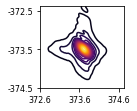

In [0]:
plt.figure(figsize= (1.5,1.5))
plt.contour(pq,20, cmap = 'inferno')
plt.xticks(np.arange(0,135,60) ,np.arange(372.6,375), fontsize=8)
plt.yticks(np.arange(0,135,60) ,np.arange(-374.5,-371.5), fontsize=8)

#plt.xlabel("Frequency (THz)", fontsize=8)
#plt.ylabel("Frequency (THz)", fontsize=8)
plt.savefig("Quant_actual.svg")

In [0]:
plt.figure(figsize=(4,4))
plt.contour(pq,20)
plt.xlabel("Frequency (THz)", fontsize=10)
plt.ylabel("Frequency (THz)", fontsize=10)

plt.savefig("Quant_actual.eps")

array([0.04557687, 0.103035  ], dtype=float32)

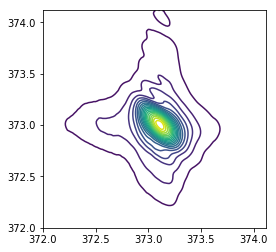

In [0]:
test(pq)

In [0]:
df1 = df[df['lambda_tu'] > 0.04]
df1 = df1[df1['lambda_tu'] < 0.048]
df1 = df1[df1['dw'] < 0.11]
df1 = df1[df1['dw'] > 0.1]
df1

,lambda_tu,dw,file
608,0.043714,0.10159,609.csv
609,0.043714,0.10476,610.csv
610,0.043714,0.10794,611.csv


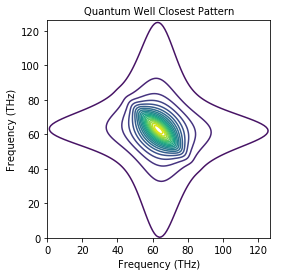

In [0]:
plt.figure(figsize=(4,4))
plt.contour(np.array(pd.read_csv('609.csv')), 20)

plt.savefig("Quant_pred.eps")

In [0]:
def test1_eps(df):
  
  df = np.array(df)
  
  df = scaler(df)
  
  
  df_extract = np.array(df)[240:280, 360:410]
  
  df_extract = cv2.resize(df_extract, dsize=(64,64))

  plt.figure()
  plt.contour(df_extract)
  plt.savefig("exp1.eps")
  
  df_extract = df_extract.reshape((1,64,64,1))
  
  k = model.predict(df_extract)[0]
  
  for i in range(2):
    if k[i] < 0:
      k[i] = 0
  
  return k

In [0]:
def test2_eps(df):
  
  df = np.array(df)/4.13
  
  df = scaler(df)
  
  
  x = 765
  y = 280
  
   
  df_extract = np.array(df)[720:850, 250:360]
  
  df_extract = cv2.resize(df_extract, dsize=(64,64))

  plt.figure()
  plt.contour(df_extract)
  plt.savefig("exp2.eps")
  
  
  df_extract = df_extract.reshape((1,64,64,1))
  
  
  return model.predict(df_extract)

In [0]:
test2_eps(exp3)

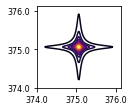

In [0]:
k_vape_sim = pd.read_csv("k_vape_sim.csv", header = None)

k_vape_sim = np.array(k_vape_sim)

plt.figure(figsize=(1.5,1.5));
plt.contour(k_vape_sim, 20, cmap = 'inferno');
plt.xticks(np.arange(0,135,60) ,np.arange(374,376.5), fontsize=8);
plt.yticks(np.arange(0,135,60) ,np.arange(374,376.5), fontsize=8);
plt.savefig("kvape_sim.svg")

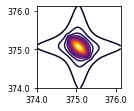

In [0]:
Q_well_sim = pd.read_csv("Q_well_sim.csv", header = None)

Q_well_sim = np.array(Q_well_sim)

plt.figure(figsize=(1.5,1.5));
plt.contour(Q_well_sim, 20, cmap = 'inferno');
plt.xticks(np.arange(0,135,60) ,np.arange(374,376.5), fontsize=8);
plt.yticks(np.arange(0,135,60) ,np.arange(374,376.5), fontsize=8);
plt.savefig("quant_sim.svg")